think about piece colour as a separate vetor, 2 training runs

In [1]:
!rm -rf __pycache__/
from flax import nnx
import chess, chess.pgn
import optax
import flax
import jax
import jax.numpy as jnp
import orbax.checkpoint as ocp
import time

from utils import *
from etils.epath import Path
from collections.abc import Sequence
import zstandard as zstd
import mmap
import struct
from typing import Any, SupportsIndex
from apache_beam import coders

NUM_EPOCHS=5
BATCH_SIZE = 2**1
LR = 0.1
LEN_FEN_BATCHES = 2
SAVE_EVERY = 10
num_positions = BATCH_SIZE*LEN_FEN_BATCHES

pychess = chess.Board()
pychess.reset()

In [2]:
file = BagFileReader("searchless_chess/state_value_data.bag")
coding = coders.TupleCoder((coders.StrUtf8Coder(),coders.FloatCoder()))

data = {}
list_of_fen = []
list_of_evals = []

for i in range(num_positions):
    # fen = str(file[i]).split("\\")[0][3::].strip()
    fen, win_prob = coding.decode(file[i])
    # print(fen,win_prob)
    if is_white_turn(fen):    
        data[fen] = win_prob_to_eval(win_prob)
    else:
        data[fen] = win_prob_to_eval(1 - win_prob)
    
list_of_fen = list(data.keys())
list_of_evals = list(data.values())

Text(0.5, 0, 'Epochs/Steps')

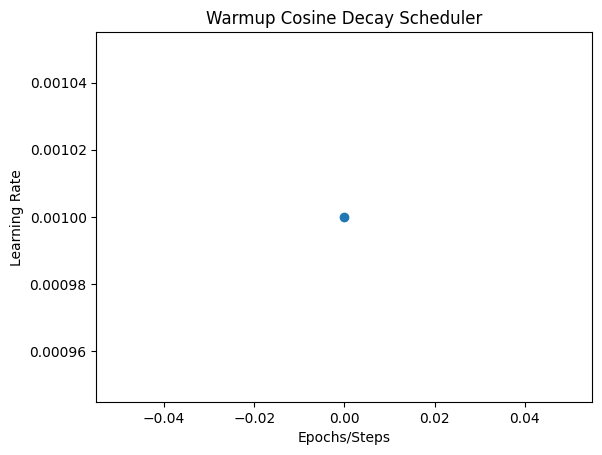

In [3]:
schedule = optax.warmup_cosine_decay_schedule(
    init_value=0.001,
    peak_value=0.1,
    warmup_steps=NUM_EPOCHS*0.4*LEN_FEN_BATCHES,
    decay_steps=NUM_EPOCHS*LEN_FEN_BATCHES,
    end_value=0.001
)

lrs = [schedule(i) for i in range(0,NUM_EPOCHS*LEN_FEN_BATCHES,NUM_EPOCHS*1000)]
import matplotlib.pyplot as plt

plt.scatter(range(0,NUM_EPOCHS*LEN_FEN_BATCHES,NUM_EPOCHS*1000), lrs)
plt.title("Warmup Cosine Decay Scheduler")
plt.ylabel("Learning Rate")
plt.xlabel("Epochs/Steps")

In [4]:
# model_1 = restore_model(WS_DIR + "/checkpoints")
model_1 = create_model()


In [5]:
# model_2 = create_model()
optimizer = nnx.Optimizer(model_1, optax.adam(schedule))  # reference sharing
# optimizer = nnx.Optimizer(model_1, optax.adam(LR))  # reference sharing

@nnx.jit  # Automatic state management
def train_step(model, optimizer: nnx.Optimizer, x_and_y_batch):
    x_batch, y_batch = x_and_y_batch
    def loss_fn(model):
        y_pred = batched_model(model, x_batch)
        result = jnp.mean((y_pred.flatten() - y_batch.flatten())**2)
        # result = optax.losses.squared_error(y_pred.flatten(), y_batch.flatten()).mean()
        # print(result)
        return result

    loss, grads = nnx.value_and_grad(loss_fn)(model)
    optimizer.update(grads)  # In place updates.
    # print(model(x))
    return loss,grads



# metrics = nnx.MultiMetric(
#   loss=nnx.metrics.Average('loss'),
# )
# # Defines the loss function using `optax.softmax_cross_entropy_with_integer_labels`.
# def loss_fn(model, batch):
#     logits = jitted_batched_apply(model, batch[0])
#     # loss = optax.softmax_cross_entropy_with_integer_labels(logits=logits, labels=batch[1]).mean()
#     loss = optax.losses.squared_error(predictions=logits,targets=batch[1])
#     return loss, logits

# # Define the training step with the `flax.nnx.jit` transformation decorator.
# # @nnx.jit
# def train_step(model: Model, optimizer: nnx.Optimizer, metrics: nnx.MultiMetric, batch):
#     grad_fn = nnx.value_and_grad(loss_fn, has_aux=False)
#     (loss, logits), grads = grad_fn(model, batch)
#     metrics.update(loss=loss, logits=logits, labels=batch[1])
#     optimizer.update(grads)
    
    
    

fen_batches = [list_of_fen[i:i + BATCH_SIZE] for i in range(0, len(list_of_fen), BATCH_SIZE)]
eval_batches = [list_of_evals[i:i + BATCH_SIZE] for i in range(0, len(list_of_evals), BATCH_SIZE)]


x = list_of_fen_to_board_flattened(fen_batches[0])
y = jnp.array(eval_batches[0])


In [6]:
y_pred = batched_model(model_1, x)
y_batch =y 
for i in range(BATCH_SIZE):
    print(f"prediction: {y_pred[i].item()}, correct_value: {y[i].item()}")
print(f"MSE = {((y_pred.flatten() - y.flatten())**2).mean()}")

prediction: 7.181102752685547, correct_value: 3.8499999046325684
prediction: 4.203405857086182, correct_value: -2.5899999141693115
MSE = 28.623302459716797


In [7]:
optimizer.opt_state[0].count
# schedule(5)

OptArray( # 1 (4 B)
  value=Array(0, dtype=int32)
)

In [8]:
for epoch in range(NUM_EPOCHS):
    acc_loss = 0
    train_loss=0
    for i in range(len(fen_batches)):
        
        x_batch = list_of_fen_to_board_flattened(fen_batches[i])

        y_batch = jnp.array(eval_batches[i]).flatten()
        # print(x,y)

        losses, grads = train_step(
            model_1,
            optimizer,
            jax.device_put((x_batch, y_batch))
        )
        
        train_loss+=losses
        
    print(f"currently on {epoch=}, {train_loss/LEN_FEN_BATCHES=}")
    if epoch%SAVE_EVERY ==SAVE_EVERY-1:
        save_model(model_1, WS_DIR+f"/checkpoints/checkpoint_epoch_{epoch}")
    
batched_model(model_1, x)

currently on epoch=0, train_loss/LEN_FEN_BATCHES=Array(98.907776, dtype=float32)
currently on epoch=1, train_loss/LEN_FEN_BATCHES=Array(146.27878, dtype=float32)
currently on epoch=2, train_loss/LEN_FEN_BATCHES=Array(146.27878, dtype=float32)
currently on epoch=3, train_loss/LEN_FEN_BATCHES=Array(146.27878, dtype=float32)
currently on epoch=4, train_loss/LEN_FEN_BATCHES=Array(146.27878, dtype=float32)


Array([[-10.],
       [-10.]], dtype=float32)

In [9]:
# save_model(model_1, WS_DIR+f"/checkpoints")